# Classificazione Binaria: `selfMade` con K-NEAREST NEIGHOBORS

L'obiettivo è di utilizzare il modello knn per classificare se un individuo è selfmade o no e ottimizzare il parametro k (numero di vicini).

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import joblib
import sys
sys.path.append('../Scripts')
from utility import evaluate_and_save_model,plot_roc_curve

X_train = pd.read_csv("../data/splitted/X_train.csv")
X_test = pd.read_csv("../data/splitted/X_test.csv")
y_train = pd.read_csv("../data/splitted/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted/y_test.csv").values.ravel()



# Rimozione colonne inutili o problematiche
X_train = X_train.drop(columns=['source'], errors='ignore')  

#Elimino colonne costanti
X_train = X_train.loc[:, X_train.nunique() > 1]  

# Allineamento test set
X_test = X_test[X_train.columns]

# Riempio NaN residui con la mediana
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())


 # standardizzazione
Per operare correttamente gli attributi devono avere la stessa scala di valori e vanno normalizzati.



In [2]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "../models/scaler_knn.joblib")


['../models/scaler_knn.joblib']

In [3]:
k = 5
model_name = f"knn_k{k}"

# Addestramento modello KNN
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train_scaled, y_train)

# Predizioni
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

KeyboardInterrupt: 

In [ ]:
evaluate_and_save_model(
    model,
    "KNN",
    y_train,
    y_pred_train,
    y_test,
    y_pred_test,
    "../results/classification_selfMade/KNN",
    "../models/knn_selfmade.joblib",
    {"k":k}
)

# Metodo del gomito
Viene valutata l'accuracy del modello per k da 1 a 20

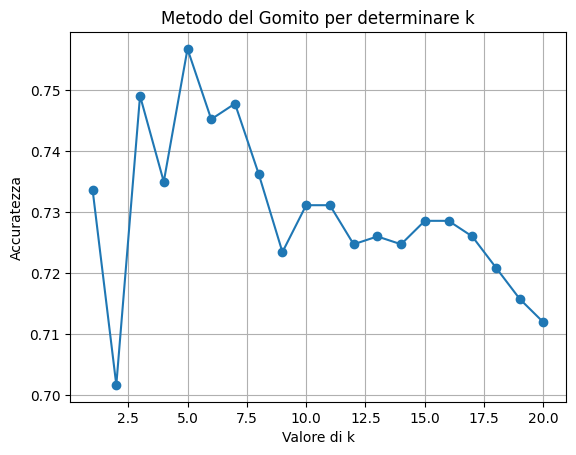

Grafico salvato in: ../results/classification_selfMade/KNN/gomito_KNN_accuracy.png


In [5]:


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Valore di k')
plt.ylabel('Accuratezza')
plt.title('Metodo del Gomito per determinare k')
plt.grid(True)
output_path = "../results/classification_selfMade/KNN/gomito_KNN_accuracy.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

print(f"Grafico salvato in: {output_path}")



# Cross validation
Su un range di k da 1 a 20 viene fatta la 5-fold cv calcola l'accuracy media e salva i risultati

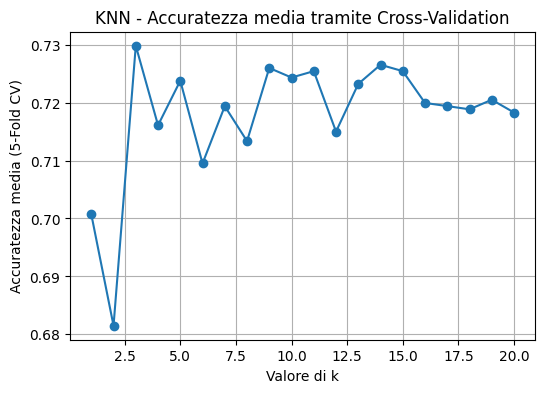

 Miglior valore di k trovato con CV e concentrazione su accuracy: 3


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(6, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Valore di k")
plt.ylabel("Accuratezza media (5-Fold CV)")
plt.title("KNN - Accuratezza media tramite Cross-Validation")
plt.grid(True)


output_path = "../results/classification_selfMade/KNN/cv_knn_accuracy.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

# Miglior k
best_k = k_values[np.argmax(cv_scores)]
print(f" Miglior valore di k trovato con CV e concentrazione su accuracy: {best_k}")



# Cross validation
Stessa procedura ma questa volta usando scoring=f1

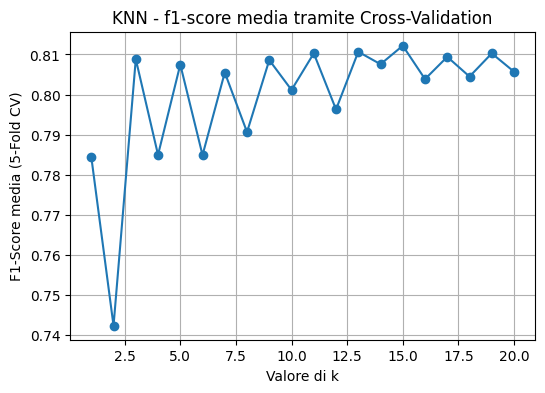

✔ Miglior valore di k trovato con CV e concentrazione su f1: 15


In [7]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

#  Plot
plt.figure(figsize=(6, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Valore di k")
plt.ylabel("F1-Score media (5-Fold CV)")
plt.title("KNN - f1-score media tramite Cross-Validation")
plt.grid(True)

# Salvataggio
output_path = "../results/classification_selfMade/KNN/cv_knn_f1.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

# Miglior k
best_k = k_values[np.argmax(cv_scores)]
print(f"✔ Miglior valore di k trovato con CV e concentrazione su f1: {best_k}")




Dai risultati ottenuti come possiamo vedere c'è un divario tra il k suggerito utilizzando cv con scoring accuracy e quello suggerito utilizzando cv con scoring su f1 rispettivamente 3 e 15. Mentre il metodo del gomito suggeriva un valore di k=5

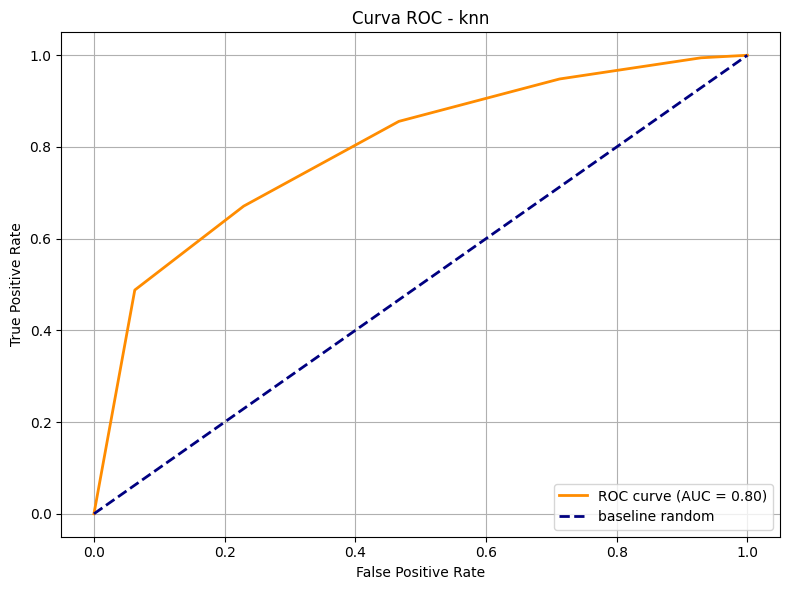

np.float64(0.7959835181762168)

In [4]:
plot_roc_curve(model, X_test_scaled, y_test, "knn",f"../results/classification_selfMade/roc")
